<a href="https://colab.research.google.com/github/rohitrrk22/Deep-Learning/blob/master/Deep_Learning_NLP/Spam_Filter_For_Quora_Questions/GLOVE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 2.x

In [2]:
import pandas as pd
import numpy as np

In [3]:
#Getting the data
!wget https://www.dropbox.com/sh/kpf9z73woodfssv/AAAw1_JIzpuVvwteJCma0xMla

--2020-08-30 07:56:30--  https://www.dropbox.com/sh/kpf9z73woodfssv/AAAw1_JIzpuVvwteJCma0xMla
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.1, 2620:100:6016:1::a27d:101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /sh/raw/kpf9z73woodfssv/AAAw1_JIzpuVvwteJCma0xMla [following]
--2020-08-30 07:56:31--  https://www.dropbox.com/sh/raw/kpf9z73woodfssv/AAAw1_JIzpuVvwteJCma0xMla
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc803704ef4d85ccd34995b5656b.dl.dropboxusercontent.com/zip_download_get/Ah3aTwDDhebus-JCLTwo4I9n1uR0TB16k_7ZcTgLzXEupq3pyA3Juv0nqRIMoIOnQNGB05RQebAphWSFaCaN5oJZI3GHvZG_Sp2E63UevxazGA [following]
--2020-08-30 07:56:31--  https://uc803704ef4d85ccd34995b5656b.dl.dropboxusercontent.com/zip_download_get/Ah3aTwDDhebus-JCLTwo4I9n1uR0TB16k_7ZcTgLzXEupq3pyA3Juv0nqRIMoIOnQNGB05RQebAphWSFaCaN5oJZI

In [4]:
train = pd.read_csv(r'/content/spam_quora_data',encoding='ISO-8859-1')

In [5]:
train.dropna(axis=0 , how='any',inplace=True)
train.rename(columns={'PK': 'qid'},inplace=True)

In [6]:
train.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0.0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0.0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0.0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0.0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0.0


In [7]:
from sklearn.model_selection import train_test_split

#Train & Test dataset
quora_train,quora_test=train_test_split(train,test_size=0.2,random_state=2)


In [8]:
del quora_train["qid"]

In [9]:
quora_train["target"].value_counts()

0.0    980078
1.0     64819
Name: target, dtype: int64

In [10]:
#Train dataset split into train & validation dataset
quora_trn,quora_val=train_test_split(quora_train,test_size=0.2,random_state=2)

x_train=quora_trn['question_text']
y_train=quora_trn['target']
x_test=quora_val['question_text']     
y_test=quora_val['target']

In [11]:
y_test.shape

(208980,)

In [12]:
!wget http://nlp.stanford.edu/data/glove.42B.300d.zip

--2020-08-30 07:57:04--  http://nlp.stanford.edu/data/glove.42B.300d.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.42B.300d.zip [following]
--2020-08-30 07:57:04--  https://nlp.stanford.edu/data/glove.42B.300d.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.42B.300d.zip [following]
--2020-08-30 07:57:04--  http://downloads.cs.stanford.edu/nlp/data/glove.42B.300d.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1877800501 (1.7G) [application/zip]
Sav

In [13]:
!unzip /content/glove.42B.300d.zip

Archive:  /content/glove.42B.300d.zip
  inflating: glove.42B.300d.txt      


In [14]:
!rm /content/glove.42B.300d.zip

In [15]:
embeding_index={}

f=open('glove.42B.300d.txt',encoding='utf-8')

for line in f:
    values=line.split()
    word=values[0]
    coefs=np.asarray(values[1:],dtype='float32')
    embeding_index[word]=coefs
f.close()
# this again will take good amount of time

In [16]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.layers import LSTM,Activation,Dense,Input,Embedding,Dropout
from tensorflow.keras.models import Model
from nltk import word_tokenize

In [17]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [18]:
sent_lens=[len(word_tokenize(x)) for x in x_train]

In [19]:
np.percentile(sent_lens,95)

30.0

In [20]:
max_len=30

tk=Tokenizer(char_level=False,split=' ')

tk.fit_on_texts(x_train)

seq_train=tk.texts_to_sequences(x_train)
seq_test=tk.texts_to_sequences(x_test)

vocab_size=len(tk.word_index)

seq_train_matrix=sequence.pad_sequences(seq_train,maxlen=max_len)
seq_test_matrix=sequence.pad_sequences(seq_test,maxlen=max_len)

In [21]:
embedding_matrix=np.zeros((vocab_size+1,300))
words_not_available=0
for word,i in tk.word_index.items():
    embed_vector=embeding_index.get(word)
    if embed_vector is not None:
        embedding_matrix[i]=embed_vector
    else:
      words_not_available+=1

In [22]:
# Now while creating the model for text data , we'll keep embedding layer weights 
# non-trainable as we are supplying those values from our end 

inputs=Input(name='text_input',shape=[max_len])
embed=Embedding(vocab_size+1,300,input_length=max_len,mask_zero=True,
                weights=[embedding_matrix],trainable=False)(inputs)
lstm_layer=LSTM(150)(embed)
dense1=Dense(75,activation='relu')(lstm_layer)
drop1=Dropout(0.2)(dense1)
dense2=Dense(35,activation='relu')(drop1)
drop2=Dropout(0.2)(dense2)
dense3=Dense(15,activation='relu')(drop2)
drop3=Dropout(0.2)(dense3)
final_layer=Dense(1,activation='sigmoid')(drop3)

model=Model(inputs=inputs,outputs=final_layer)

In [23]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_input (InputLayer)      [(None, 30)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 30, 300)           51964500  
_________________________________________________________________
lstm (LSTM)                  (None, 150)               270600    
_________________________________________________________________
dense (Dense)                (None, 75)                11325     
_________________________________________________________________
dropout (Dropout)            (None, 75)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 35)                2660      
_________________________________________________________________
dropout_1 (Dropout)          (None, 35)               

In [24]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [25]:
history = model.fit(
    seq_train_matrix, y_train, batch_size=120, epochs=2, validation_data=(seq_test_matrix, y_test)
)

Epoch 1/2
6966/6966 [==============================] - 521s 75ms/step - loss: 0.1228 - accuracy: 0.9527 - val_loss: 0.1100 - val_accuracy: 0.9573
Epoch 2/2
6966/6966 [==============================] - 504s 72ms/step - loss: 0.1065 - accuracy: 0.9577 - val_loss: 0.1076 - val_accuracy: 0.9582


In [26]:
#Performance on Validation dataset
model.evaluate(seq_test_matrix, y_test, batch_size=120)

1742/1742 [==============================] - 14s 8ms/step - loss: 0.1076 - accuracy: 0.9582


[0.10757720470428467, 0.9581730365753174]

In [28]:
#Prediction on Test Data Set
predict=model.predict(seq_test_matrix)

In [30]:
from sklearn.metrics import roc_auc_score,confusion_matrix
roc_auc_score(y_test,predict)

0.9623166445313538

In [31]:
#Merging train and validation data set
X_train=pd.concat([x_train,x_test],axis=0)
Y_train=pd.concat([y_train,y_test],axis=0)

In [32]:
quora_test.reset_index(drop=True,inplace=True)

In [33]:
X_test=quora_test['question_text']     
Y_test=quora_test['target']

In [34]:
# X_test.reset_index(drop=True,inplace=True)
# Y_test.reset_index(drop=True,inplace=True)

In [35]:
sent_lens=[len(word_tokenize(x)) for x in X_train]

In [36]:
np.percentile(sent_lens,95)

30.0

In [37]:
max_len=30

tk=Tokenizer(char_level=False,split=' ')

tk.fit_on_texts(X_train)

seq_train=tk.texts_to_sequences(X_train)
seq_test=tk.texts_to_sequences(X_test)

vocab_size=len(tk.word_index)

seq_train_matrix=sequence.pad_sequences(seq_train,maxlen=max_len)
seq_test_matrix=sequence.pad_sequences(seq_test,maxlen=max_len)

In [38]:
embedding_matrix=np.zeros((vocab_size+1,300))
words_not_available=0
for word,i in tk.word_index.items():
    embed_vector=embeding_index.get(word)
    if embed_vector is not None:
        embedding_matrix[i]=embed_vector
    else:
      words_not_available+=1

In [39]:
# LSTM Model with Glove Embedding Layer

inputs=Input(name='text_input',shape=[max_len])
embed=Embedding(vocab_size+1,300,input_length=max_len,mask_zero=True,
                weights=[embedding_matrix],trainable=False)(inputs)
lstm_layer=LSTM(150)(embed)
dense1=Dense(75,activation='relu')(lstm_layer)
drop1=Dropout(0.2)(dense1)
dense2=Dense(35,activation='relu')(drop1)
drop2=Dropout(0.2)(dense2)
dense3=Dense(15,activation='relu')(drop2)
drop3=Dropout(0.2)(dense3)
final_layer=Dense(1,activation='sigmoid')(drop3)

model=Model(inputs=inputs,outputs=final_layer)

model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_input (InputLayer)      [(None, 30)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 30, 300)           58866300  
_________________________________________________________________
lstm_1 (LSTM)                (None, 150)               270600    
_________________________________________________________________
dense_4 (Dense)              (None, 75)                11325     
_________________________________________________________________
dropout_3 (Dropout)          (None, 75)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 35)                2660      
_________________________________________________________________
dropout_4 (Dropout)          (None, 35)               

In [40]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

history=model.fit(seq_train_matrix,Y_train,validation_data=(seq_test_matrix,Y_test),epochs=2,batch_size=150)

Epoch 1/2
6966/6966 [==============================] - 525s 75ms/step - loss: 0.1213 - accuracy: 0.9534 - val_loss: 0.1117 - val_accuracy: 0.9563
Epoch 2/2
6966/6966 [==============================] - 488s 70ms/step - loss: 0.1051 - accuracy: 0.9583 - val_loss: 0.1026 - val_accuracy: 0.9590


In [42]:
model.evaluate(seq_test_matrix, Y_test, batch_size=150)

1742/1742 [==============================] - 14s 8ms/step - loss: 0.1026 - accuracy: 0.9590


[0.10263634473085403, 0.9589855670928955]

In [43]:
#Prediction on Test Data Set
predict=model.predict(seq_test_matrix)

In [44]:
from sklearn.metrics import roc_auc_score,confusion_matrix
roc_auc_score(Y_test,predict)

0.9631517481778409

In [45]:
Y_Predicted = pd.DataFrame(predict, index=range(predict.shape[0]),
                     columns=range(predict.shape[1]))

In [46]:
Y_Predicted = np.where(Y_Predicted > 0.5, 1, 0)
Y_test=Y_test.astype(int)

In [47]:
Y_Predicted = pd.DataFrame(list(Y_Predicted),columns=['Predicted Target'])
Y_Actual = pd.DataFrame(Y_test.values,columns=["Actual Target"])
Final_Comparison=pd.concat([quora_test['qid'],quora_test['question_text'],Y_Actual,Y_Predicted],axis=1)

In [48]:
Final_Comparison.head(10)

,qid,question_text,Actual Target,Predicted Target
0,8747d2afef04f494fd71,"How does stopping refugee families, women and ...",1,0
1,5ad7be48609f9b63a5b0,What makes you start your business?,0,0
2,be9e2e86a915f88212f9,"Someone said they wouldn't give me something ""...",0,0
3,bc721413105adba6d757,What is best option for a disqualified medical...,0,0
4,79a5f298b4b5dbac4dd7,What are the best sites to create apps on Andr...,0,0
5,ff1fd33a96c6c72b61b6,Which is the best homeopathic face wash for wo...,0,0
6,251b29aa445efc14aa04,Is it possible that the laws of physics may ha...,0,0
7,412350e4aaa272a16f81,What's your take on the dispute between core d...,0,0
8,bfd87b2feffdeee55656,What is the basic difference between Automatic...,0,0
9,99a93d95d6d030de6205,How is the taste of SirkkaleipÃ¤?,0,0


In [49]:
confusion_matrix(Y_Actual,Y_Predicted)

array([[241525,   3709],
       [  7005,   8986]])

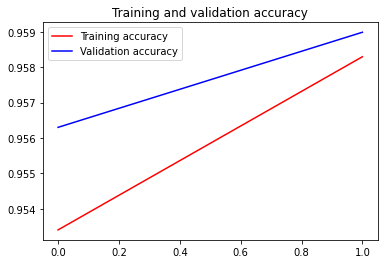

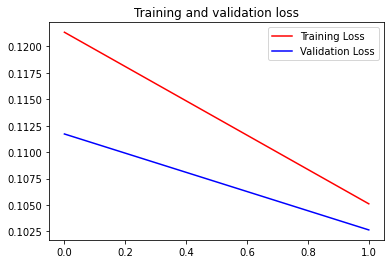

In [50]:
# Plot the chart for accuracy and loss on both training and validation
%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()